#### Step 1: Movement Dataset Class

In [26]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [27]:
df = pd.read_csv('movement_sequences.csv')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [28]:
print(train_df.iloc[:, -1].value_counts())
print(test_df.iloc[:, -1].value_counts())

direction
up       108
down     100
right     98
left      97
Name: count, dtype: int64
direction
left     29
right    28
down     26
up       18
Name: count, dtype: int64


In [29]:
class MovementSequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.num_frames = 100

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = []
        for i in range(self.num_frames):
            frame = json.loads(self.data.iloc[idx, i])
            flattened_frame = np.array(frame).flatten()
            frames.append(flattened_frame)
        frames = np.array(frames)
        direction = self.data.iloc[idx, self.num_frames]
        direction_label = self.direction_to_label(direction)

        return torch.tensor(frames, dtype=torch.float32), torch.tensor(direction_label, dtype=torch.long)

    def direction_to_label(self, direction):
        direction_mapping = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
        return direction_mapping[direction]

train_dataset = MovementSequenceDataset(train_df)
test_dataset = MovementSequenceDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for inputs, labels in train_dataloader:
    print("Input batch shape:", inputs.shape)
    print("Labels batch shape:", labels.shape)
    print("First input example:", inputs[0][0])
    break


Input batch shape: torch.Size([32, 100, 49])
Labels batch shape: torch.Size([32])
First input example: tensor([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1., 200.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.])


In [30]:
def plot_spike_tensor(spk_tensor, title):
    # Generate the plot
    spk_tensor = spk_tensor.T
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot spikes
    splt.raster(spk_tensor, ax, s=0.5, c="black")  # Transpose to align with neurons on y-axis

    # Set labels and title
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Neuron")
    ax.set_title(title)

    plt.show()

def simple_branching_param(bin_size, spikes):  # spikes in shape of [units, time]
    run_time = spikes.shape[1]
    nbins = spikes.shape[1]
    # nbins = int(np.round(run_time / bin_size))
    # for every pair of timesteps, determine the number of ancestors
    # and the number of descendants
    numA = torch.zeros(nbins - 1)
    # number of ancestors for each bin
    numD = torch.zeros(nbins - 1)
    # number of descendants for each ancestral bin
    i = 0
    while i < (numA.size(0) - 1):
        numA[i] = torch.sum(spikes[:, i] == 1).item()
        numD[i] = torch.sum(spikes[:, i + bin_size] == 1).item()
        # Check if numA[i] is 0, and remove numA[i] and numD[i] if it is
        if numA[i] == 0:
            numA = torch.cat((numA[:i], numA[i+1:]))
            numD = torch.cat((numD[:i], numD[i+1:]))
        else:
            i+=1
    # the ratio of descendants per ancestor
    d = numD / numA
    bscore = torch.nanmean(d)
    return bscore


# Synchrony -- Fano Factor
def fano_factor(seq_len, spike):
    # Calculate value similar to the Fano factor to estimate synchrony quickly
    # During each bin, calculate the variance of the number of spikes per neuron divided by the mean of the number of spikes per neuron
    # The Fano factor during one interval is equal to the mean of the values calculated for each bin in it
    # Spike should have dims of neuron, time
    # Returned fano factor should have dims of trial
    len_bins = 10  # ms
    n_bins = int(round(seq_len / len_bins))
    fano_all = torch.zeros(n_bins)
    for i in range(n_bins):
        spike_slice = spike[:, i * len_bins:(i + 1) * len_bins]
        spikes_per_neuron = torch.sum(spike_slice, axis=1)
        variance_spikes = torch.var(spikes_per_neuron)
        mean_spikes = torch.mean(spikes_per_neuron)
        fano_bin = variance_spikes / mean_spikes if mean_spikes != 0 else 0
        fano_all[i] = fano_bin
    n_fano = torch.mean(fano_all)
    return n_fano


In [31]:
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # Randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx

# creates an excitatory and inhibitory matrix
def hid_mx(rows, columns, num_excitatory, num_inhibitory):
    # hard coded sparsity

    # Initialize the weight matrix
    weight_matrix = np.zeros((num_excitatory + num_inhibitory, num_excitatory + num_inhibitory))

    # Set excitatory to excitatory connections
    weight_matrix[:num_excitatory, :num_excitatory] = np.random.choice([0, 1], size=(num_excitatory, num_excitatory), p=[1-0.16, 0.16])

    # Set excitatory to inhibitory connections
    weight_matrix[:num_excitatory, num_excitatory:] = np.random.choice([0, 1], size=(num_excitatory, num_inhibitory), p=[1-0.205, 0.205])

    # Set inhibitory to excitatory connections
    weight_matrix[num_excitatory:, :num_excitatory] = np.random.choice([0, -1], size=(num_inhibitory, num_excitatory),p=[1-0.252, 0.252])

    # Set inhibitory to inhibitory connections
    weight_matrix[num_excitatory:, num_excitatory:] = np.random.choice([0, -1], size=(num_inhibitory, num_inhibitory), p=[1-0.284, 0.284] )

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    weight_matrix[non_zero_indices] = np.random.lognormal(mean=mu, sigma=sigma, size=non_zero_indices[0].shape)

    # Multiply the last num_inhibitory rows by -10
    weight_matrix[-num_inhibitory:, :] *= -10

    return torch.tensor(weight_matrix.astype(np.float32))

In [32]:
import torch.nn as nn

class CustomLoss(nn.Module):

    def __init__(self, target_synchrony=1.4, target_firing_rate=0.05, target_branching=1.0):
        super(CustomLoss, self).__init__()
        self.target_synchrony = torch.tensor(target_synchrony, requires_grad=False)
        self.target_firing_rate = torch.tensor(target_firing_rate, requires_grad=False)
        self.target_branching = torch.tensor(target_branching, requires_grad=False)
        self.criterion_classification = nn.CrossEntropyLoss()
        self.criterion_continuous = nn.MSELoss()

    def forward(self, outputs, targets, criticality, firing_rate, synchrony_fano_factor):
        batch_size = targets.size(0)
        
        # Classification loss
        classification_loss = self.criterion_classification(outputs, targets)
        
        # Continuous losses
        rate_loss = self.criterion_continuous(firing_rate, self.target_firing_rate.expand_as(firing_rate))
        criticality_loss = self.criterion_continuous(criticality, self.target_branching.expand_as(criticality))
        synchrony_loss = self.criterion_continuous(synchrony_fano_factor, self.target_synchrony.expand_as(synchrony_fano_factor))

        # print("classification_loss:", classification_loss.item())
        # print("rate_loss:", rate_loss.item())
        # print("criticality_loss:", criticality_loss.item())
        # print("synchrony_loss:", synchrony_loss.item())

        # Weight the losses
        w_classification = 3
        w_rate = 1.5
        w_criticality = 0
        w_synchrony = 0

        total_loss = (
            w_classification * classification_loss +
            w_rate * rate_loss +
            w_criticality * criticality_loss
        )

        # if torch.isnan(total_loss):
        #     print("NaN encountered in loss calculation")
        #     print("Outputs:", outputs)
        #     print("Targets:", targets)
        #     print("Criticality:", criticality)
        #     print("Firing Rate:", firing_rate)
        #     print("Synchrony Fano Factor:", synchrony_fano_factor)
            
        return total_loss


In [33]:
import os
import torch
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import torch.nn.init as init

class RSNN_direction(nn.Module):
    def __init__(self):
        super(RSNN_direction, self).__init__()
        num_inputs = 49
        num_hidden = 256
        num_output = 4
        beta = 0.85
        pe_e = 0.16

        # self.surrogate_grad = surrogate.sigmoid(slope=25)

        # Define the dimensions
        num_excitatory = 205
        self.num_excitatory = num_excitatory
        num_inhibitory = 51
        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        init.kaiming_uniform_(self.l1.weight)
        self.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_hidden,num_hidden,num_excitatory,num_inhibitory)
        self.rlif1 = snn.RLeaky(reset_mechanism="zero",threshold=10, beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T

        # hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        init.kaiming_uniform_(self.l2.weight)
        self.l2.weight.data = hid_out_mx.T


    def forward(self, inputs):
        spk1,mem1 = self.rlif1.init_rleaky()
        self.spk1_rec = []
        self.cur2_rec = []

        # print(inputs.shape)
        for step in range(inputs.shape[0]):
            cur_input = inputs[step,:]
            cur1 = self.l1(cur_input)
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)

        self.spk1_rec = torch.stack(self.spk1_rec)
        self.cur2_rec = torch.stack(self.cur2_rec)
        cur2_rec = self.cur2_rec.mean(dim=0)  # Average over timesteps
        # print("Shape of cur2_rec before softmax:", cur2_rec.shape)

        output = nn.functional.softmax(cur2_rec, dim=-1)  # Apply softmax

        return output, self.spk1_rec

    def positive_negative_weights(self):
        excitatory_weights = self.rlif1.recurrent.weight.data[:, :self.num_excitatory]
        inhibitory_weights = self.rlif1.recurrent.weight.data[:, self.num_excitatory:]

        #save the number of positives in inhibitory and negatives in excitatory region
        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        self.false_neg.append(num_false_neg)
        self.false_pos.append(num_false_pos)

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        mu = -0.64
        sigma = 0.51


        #change the code so that for any vanishing excitatory neuron, populate another excitatory.

        #following code picks random indices from excitatory and inhibitory originating weights
        #for the number of num_false_neg and num_false_neg for inhibitory and excitatory originating weights respectively
        #assigns them with the lognormal dist
        excitatory_zero_indices = (self.rlif1.recurrent.weight.data[:, :self.num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (self.rlif1.recurrent.weight.data[:, self.num_excitatory:] == 0).nonzero(as_tuple=True)

        if (len(excitatory_zero_indices) > num_false_pos):
            excitatory_sampled_indices = torch.stack([
                    excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                    excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
                ], dim=1)

            # generating self.excitatory_changes number of lognormal values
            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            self.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if (len(inhibitory_zero_indices) > num_false_neg):
            inhibitory_sampled_indices = torch.stack([
                    inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                    inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
                ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            self.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], self.num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values


Epoch [1/100], Loss: 1.4035
Epoch [2/100], Loss: 1.3569
Epoch [3/100], Loss: 1.3253
Epoch [4/100], Loss: 1.2993
Epoch [5/100], Loss: 1.2646
Epoch [6/100], Loss: 1.2455
Epoch [7/100], Loss: 1.2188
Epoch [8/100], Loss: 1.1832
Epoch [9/100], Loss: 1.1610
Epoch [10/100], Loss: 1.1927
Epoch [11/100], Loss: 1.1841
Epoch [12/100], Loss: 1.2524
Epoch [13/100], Loss: 1.3211
Epoch [14/100], Loss: 1.3152
Epoch [15/100], Loss: 1.3131
Epoch [16/100], Loss: 1.2842
Epoch [17/100], Loss: 1.2679
Epoch [18/100], Loss: 1.2612
Epoch [19/100], Loss: 1.2446
Epoch [20/100], Loss: 1.2378
Epoch [21/100], Loss: 1.2225
Epoch [22/100], Loss: 1.2136
Epoch [23/100], Loss: 1.2040
Epoch [24/100], Loss: 1.1996
Epoch [25/100], Loss: 1.1792
Epoch [26/100], Loss: 1.1805
Epoch [27/100], Loss: 1.1705
Epoch [28/100], Loss: 1.1669
Epoch [29/100], Loss: 1.1624
Epoch [30/100], Loss: 1.1487
Epoch [31/100], Loss: 1.1466
Epoch [32/100], Loss: 1.1356
Epoch [33/100], Loss: 1.1179
Epoch [34/100], Loss: 1.1169
Epoch [35/100], Loss: 1

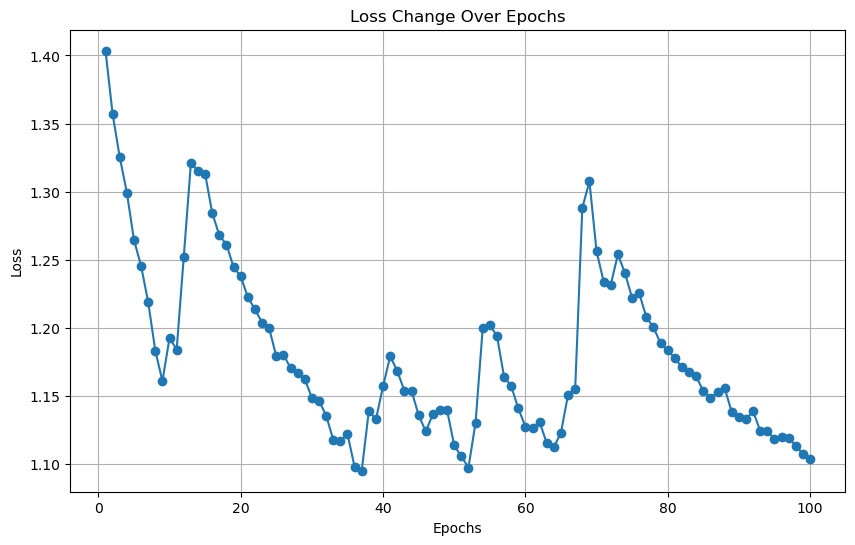

In [34]:
device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")

net = RSNN_direction().to(device)
criterion = nn.CrossEntropyLoss()
# for param in net.l1.parameters():
#     param.requires_grad = False
# for param in net.rlif1.parameters():
#     param.requires_grad = False
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, net.parameters()), lr=0.01)
num_timesteps = 100
num_epochs = 100

loss_spike_threshold = 0.35
prev_epoch_loss = float('inf')

# epoch_firing_rates = []

epoch_losses = []
input_grad = []
rec_grad =[]
output_grad =[]

epoch_input_weights =[]
epoch_output_weights =[]
epoch_recurrent_weights =[]

for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (inputs, direction_labels) in enumerate(train_dataloader):
        inputs, direction_labels = inputs.to(device), direction_labels.to(device)
        optimizer.zero_grad()

        # Initialize tensors to store intermediate values
        outputs = []
        # firing_rate_per_batch = []
        # criticality_per_batch = []
        # synchrony_per_batch = []

        for batch_idx, (input, direction_label) in enumerate(zip(inputs, direction_labels)):
            # print("Shape of input for current batch:", input.shape)  # Should be (num_timesteps, 16)
            output, spikes = net(input)
            outputs.append(output)

            # firing_rate = torch.sum(spikes) / (num_timesteps * spikes.shape[1])
            # firing_rate_per_batch.append(firing_rate)

            # criticality = simple_branching_param(10, spikes)
            # criticality_per_batch.append(criticality)

            # synchrony_fano_factor = fano_factor(num_timesteps, spikes)
            # synchrony_per_batch.append(synchrony_fano_factor)

        outputs = torch.stack(outputs)  # (batch_size, num_timesteps)
        # firing_rate_per_batch = torch.tensor(firing_rate_per_batch)
        # criticality_per_batch = torch.tensor(criticality_per_batch)
        # synchrony_per_batch = torch.tensor(synchrony_per_batch)

        direction_labels = direction_labels.long()

        # Calculate the loss
        loss = criterion(outputs, direction_labels)#, synchrony_per_batch, firing_rate_per_batch, criticality_per_batch)
        
        loss.backward()
        #  torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        # input_grad.append(net.l1.weight.grad.detach().cpu().numpy())
        # rec_grad.append(net.rlif1.recurrent.weight.grad.detach().cpu().numpy())
        output_grad.append(net.l2.weight.grad.detach().cpu().numpy())
        optimizer.step()
        batch_input_weights = net.l1.weight.data.detach().cpu().numpy()
        batch_rec_weights = net.rlif1.recurrent.weight.data.detach().cpu().numpy()
        batch_output_weights = net.l2.weight.data.detach().cpu().numpy()
        epoch_loss += loss.item()
        # epoch_firing_rate += torch.mean(firing_rate_per_batch).item()
        

    epoch_loss /= len(train_dataloader)
    epoch_losses.append(epoch_loss)
    # epoch_firing_rate /= len(train_dataloader)  # Average firing rate for the epoch
    # epoch_firing_rates.append(epoch_firing_rate)  # Store firing rate
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    epoch_input_weights.append(batch_input_weights)
    epoch_recurrent_weights.append(batch_rec_weights)
    epoch_output_weights.append(batch_output_weights)
    # Check for loss spike
    if epoch_loss > prev_epoch_loss + loss_spike_threshold:
        print(f"Loss spike detected at epoch {epoch+1}. Aborting training.")
        break

    # Update previous loss
    prev_epoch_loss = epoch_loss


print("Training completed")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Loss Change Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [35]:
print(len(epoch_input_weights))

100


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


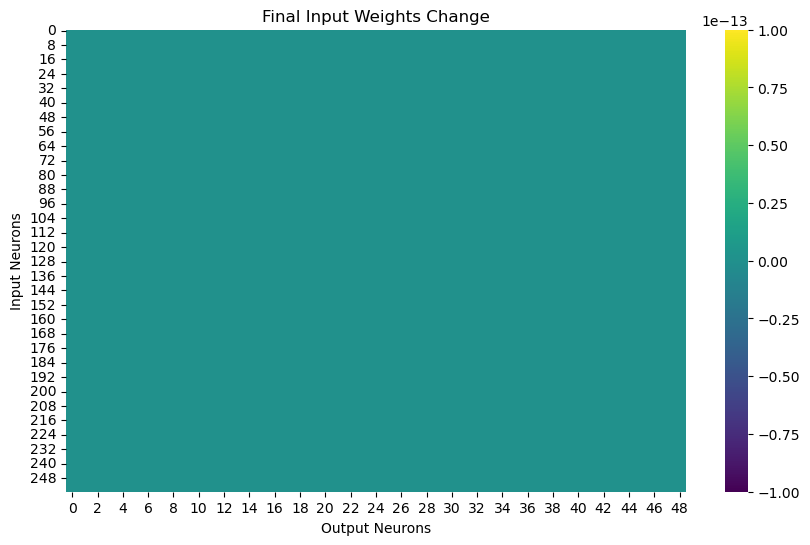

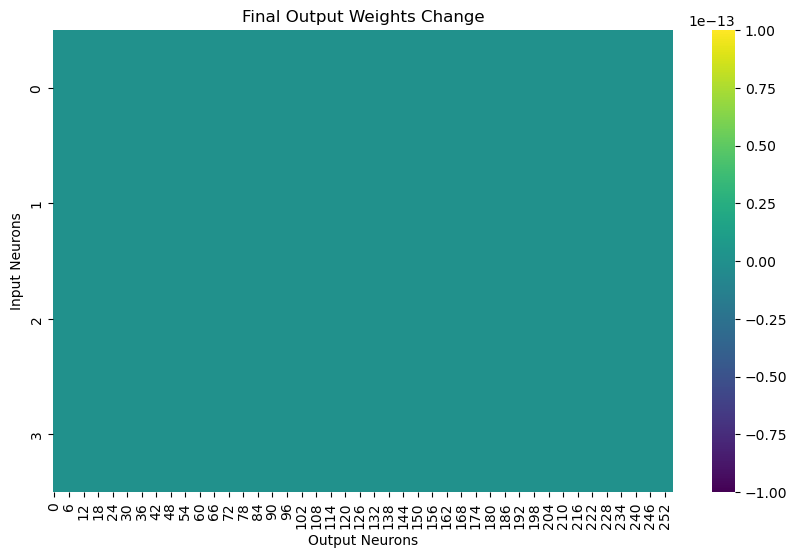

In [36]:
import seaborn as sns

initial_output_weights = epoch_output_weights[0]
final_output_weights = epoch_output_weights[-1]
initial_input_weights = epoch_input_weights[0]
final_input_weights = epoch_input_weights[-1]
initial_recur_weights = epoch_recurrent_weights[0]
final_recur_weights = epoch_recurrent_weights[-1]

# Function to plot heatmaps of weights
def plot_weight_heatmap(weights, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(weights, cmap='viridis', annot=False, vmin = -0.0000000000001,vmax = 0.0000000000001)
    plt.title(title)
    plt.xlabel('Output Neurons')
    plt.ylabel('Input Neurons')
    plt.show()

print(final_output_weights-initial_output_weights)
plot_weight_heatmap(final_input_weights-initial_input_weights, 'Final Input Weights Change')
plot_weight_heatmap(final_output_weights-initial_output_weights, 'Final Output Weights Change')


TypeError: Invalid shape (49,) for image data

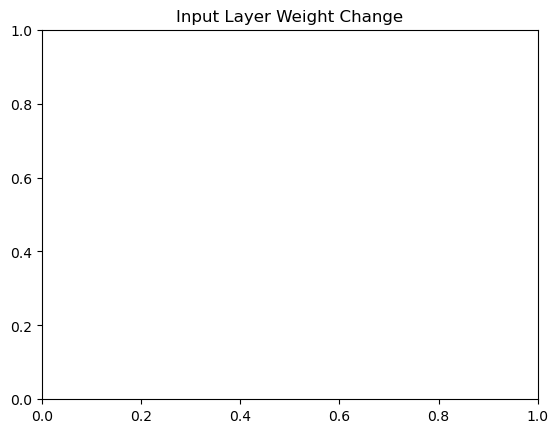

In [37]:
Input_weight_changes = epoch_input_weights[99][1] - epoch_input_weights[0][1]
plt.title('Input Layer Weight Change')
plt.imshow(Input_weight_changes, aspect='auto', cmap='viridis', vmin= -0.000000005, vmax=0.000000005)
plt.colorbar()

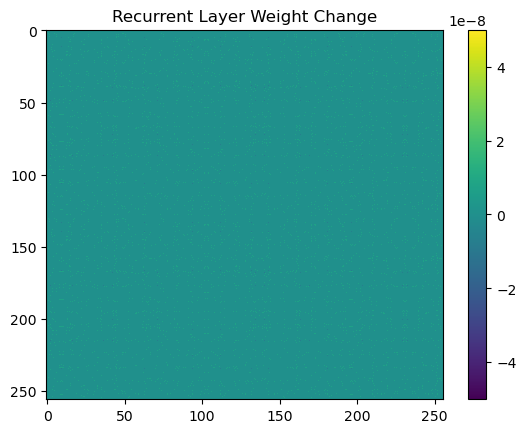

In [ ]:
recurrent_weight_changes = epoch_recurrent_weights[99][1]-epoch_recurrent_weights[0][1]
plt.title('Recurrent Layer Weight Change')
plt.imshow(recurrent_weight_changes, aspect='auto', cmap='viridis', vmin= -0.00000005, vmax=0.00000005)
plt.colorbar()

In [45]:
print(epoch_output_weights)[1]

[array([[ 1.3358152 ,  0.79039854,  0.12988032, ..., -1.4873405 ,
         0.38154662, -0.3727542 ],
       [-0.11005252, -0.72792387,  1.2827684 , ..., -0.00214159,
         0.14509533,  0.08689649],
       [-0.9562373 ,  0.27119637,  0.6178125 , ..., -0.5843605 ,
         0.94477683,  1.1015472 ],
       [-0.4301261 , -0.53823876,  0.56705016, ...,  1.8749008 ,
        -0.62332046, -0.86641693]], dtype=float32), array([[ 1.3358152 ,  0.79039854,  0.12988032, ..., -1.4873405 ,
         0.38154662, -0.3727542 ],
       [-0.11005252, -0.72792387,  1.2827684 , ..., -0.00214159,
         0.14509533,  0.08689649],
       [-0.9562373 ,  0.27119637,  0.6178125 , ..., -0.5843605 ,
         0.94477683,  1.1015472 ],
       [-0.4301261 , -0.53823876,  0.56705016, ...,  1.8749008 ,
        -0.62332046, -0.86641693]], dtype=float32), array([[ 1.3358152 ,  0.79039854,  0.12988032, ..., -1.4873405 ,
         0.38154662, -0.3727542 ],
       [-0.11005252, -0.72792387,  1.2827684 , ..., -0.00214159,


TypeError: 'NoneType' object is not subscriptable

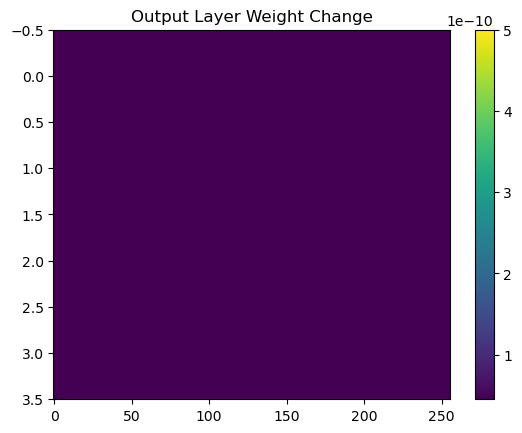

In [ ]:
Output_weight_changes = epoch_output_weights[99][1]-epoch_output_weights[0][1]
plt.title('Output Layer Weight Change')
plt.imshow(Output_weight_changes, aspect='auto', cmap='viridis', vmin = 0.0000000005, vmax = 0.00000000005)
plt.colorbar()

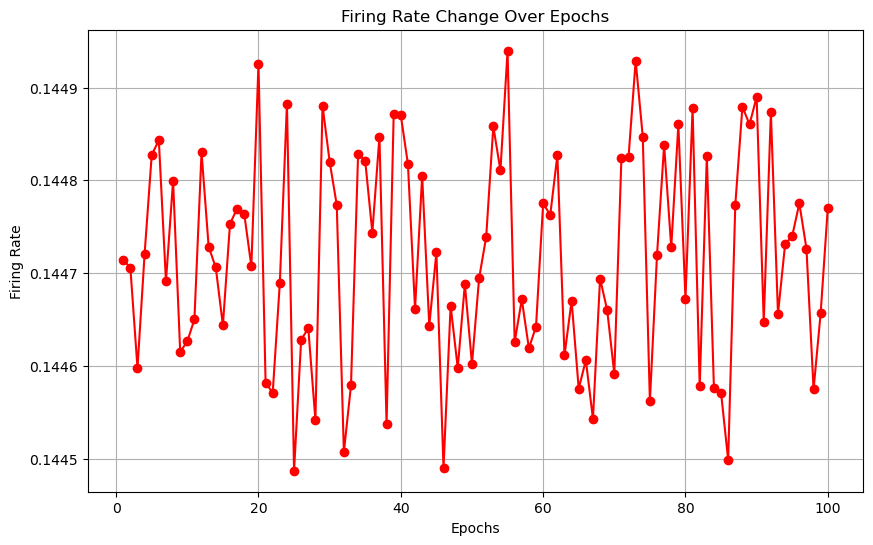

In [ ]:
# Plot firing rate change over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_firing_rates) + 1), epoch_firing_rates, marker='o', color='r')
plt.title('Firing Rate Change Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Firing Rate')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap="viridis", annot=False)
    plt.title(title)
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.show()

In [ ]:
# print input layer gradients
print(len(input_grad))
# print(input_grad[359])
first_epoch = input_grad[1]
plot_heatmap(first_epoch,'Input gradient at the first epoch')
last_epoch = input_grad[359]
plot_heatmap(first_epoch, 'Input gradient at the last epoch')

0


IndexError: list index out of range

In [ ]:
print(len(rec_grad))
# print recurrent layer gradient
first_epoch = rec_grad[1]
plot_heatmap(first_epoch,'Recurrent gradient at the first epoch')
last_epoch = rec_grad[299]
plot_heatmap(first_epoch, 'Recurrent gradient at the last epoch')

0


IndexError: list index out of range

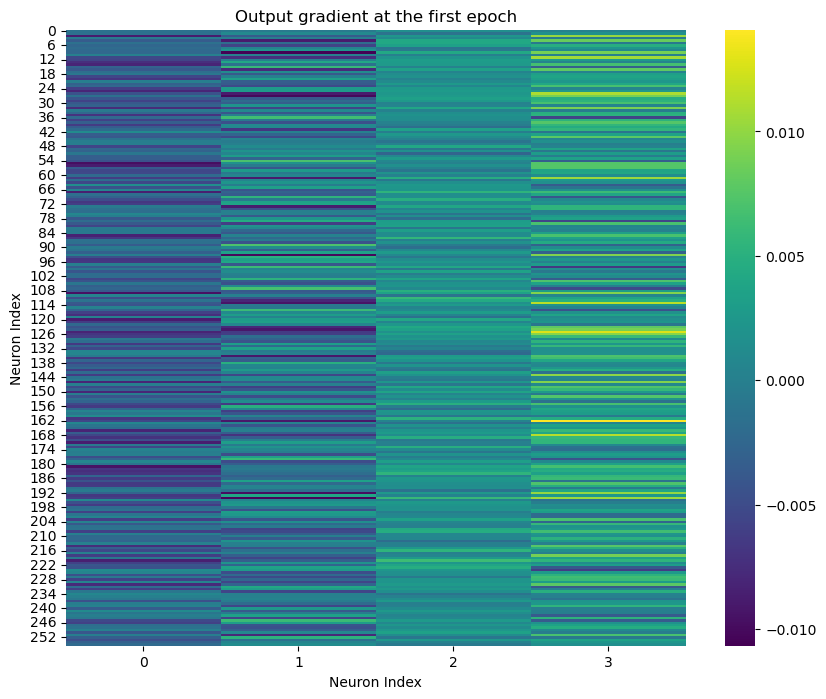

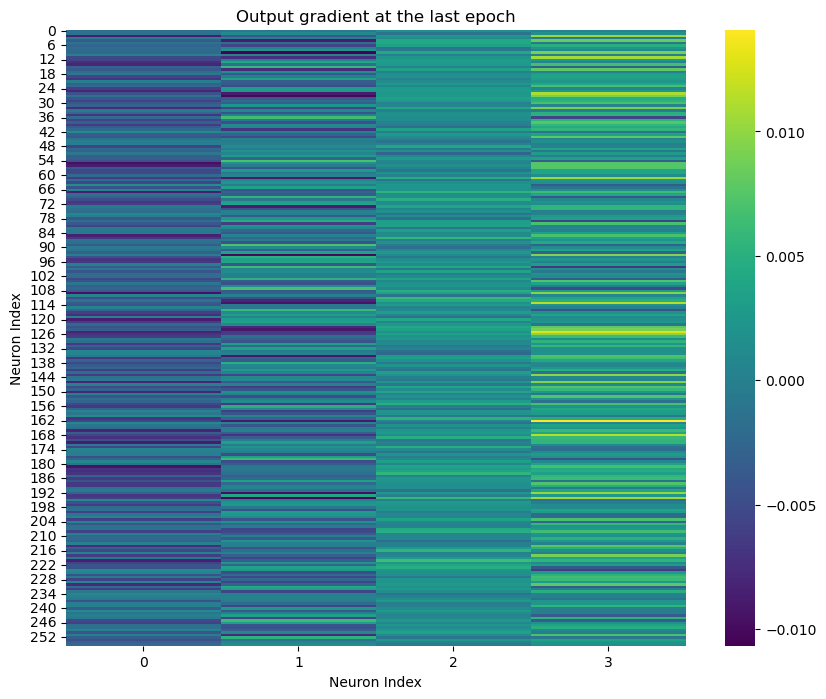

In [ ]:
first_epoch = output_grad[1].T
plot_heatmap(first_epoch,'Output gradient at the first epoch')
last_epoch = output_grad[299].T
plot_heatmap(first_epoch, 'Output gradient at the last epoch')

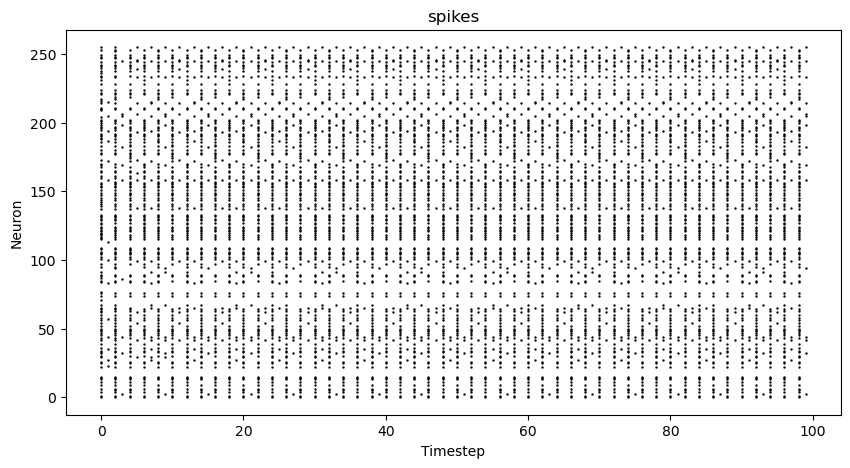

In [46]:
# print(spikes)
plot_spike_tensor(spikes.T, "spikes")

In [47]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, direction_labels) in enumerate(dataloader):
            batch_size = inputs.size(0)
            outputs = []

            for input in inputs:
                output, _ = model(input)
                outputs.append(output)
            outputs = torch.stack(outputs)  # (batch_size, num_classes)

            # print(f"Batch {batch_idx+1} Outputs Shape: {outputs.shape}\n", outputs)

            predicted = outputs.argmax(dim=1)
            print(f"Batch {batch_idx+1} Predicted Labels: {predicted}")
            print(f"Batch {batch_idx+1} True Labels: {direction_labels}")
            total += direction_labels.size(0)
            correct += (predicted == direction_labels).sum().item()

    accuracy = correct/total
    return accuracy

test_accuracy = evaluate_model(net, test_dataloader)
print("Test Accuracy:", test_accuracy)


Batch 1 Predicted Labels: tensor([1, 1, 3, 3, 1, 3, 2, 2, 0, 0, 2, 2, 0, 1, 3, 0, 3, 0, 1, 2, 0, 2, 1, 0,
        0, 3, 1, 2, 3, 2, 1, 0])
Batch 1 True Labels: tensor([1, 1, 1, 2, 1, 3, 2, 1, 3, 1, 1, 2, 3, 0, 3, 0, 3, 2, 1, 1, 0, 2, 3, 1,
        2, 2, 0, 2, 2, 3, 1, 1])
Batch 2 Predicted Labels: tensor([0, 3, 0, 3, 2, 3, 1, 1, 2, 2, 3, 0, 1, 2, 0, 1, 0, 2, 2, 3, 1, 3, 3, 2,
        0, 3, 1, 3, 3, 2, 2, 2])
Batch 2 True Labels: tensor([1, 3, 2, 3, 0, 3, 1, 2, 2, 3, 0, 0, 0, 3, 0, 1, 3, 0, 2, 3, 3, 3, 3, 2,
        1, 2, 2, 3, 3, 2, 2, 2])
Batch 3 Predicted Labels: tensor([0, 2, 1, 1, 1, 0, 2, 3, 0, 2, 1, 0, 0, 3, 0, 0, 1, 0, 3, 0, 0, 0, 0, 3,
        1, 0, 2, 0, 1, 2, 0, 3])
Batch 3 True Labels: tensor([2, 1, 1, 1, 3, 1, 2, 3, 0, 2, 3, 2, 0, 3, 0, 3, 1, 1, 3, 0, 3, 0, 1, 3,
        1, 0, 2, 0, 1, 2, 1, 2])
Batch 4 Predicted Labels: tensor([2, 3, 2, 0, 1])
Batch 4 True Labels: tensor([2, 3, 2, 0, 2])
Test Accuracy: 0.5544554455445545


In [ ]:
net = RSNN_direction()
criterion = CustomLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
num_epochs = 60

sparsity_list = []
num_timesteps = 100
weights = net.rlif1.recurrent.weight.data

loss_list = []
synch_list = []
rate_list = []
crit_list = []
c = 0

for epoch in range(num_epochs):
    mse_epoch_loss = 0
    rate_epoch_loss = 0
    synchrony_epoch_loss = 0
    criticality_epoch_loss = 0

    # # Initialize lists to hold data
    # batch_loss_list = []
    # mse_batch_loss_list = []
    # rate_batch_loss_list = []
    # synchrony_batch_loss_list = []
    # criticality_batch_loss_list = []
    # spikes_list = []
    # input_weights_list = []
    # rec_weights_list = []
    # output_weights_list = []
    # inputs_list = []
    # outputs_list = []
    # targets_list = []

    for i, (inputs, direction_labels) in enumerate(dataloader):
        optimizer.zero_grad()

        outputs = torch.empty((inputs.size(0), num_timesteps, 1), dtype=torch.float32, requires_grad=True)
        firing_rate_per_batch = []
        criticality_per_batch = []
        synchrony_per_batch = []

        for batch_idx, (input, direction_label) in enumerate(zip(inputs, direction_labels)):
            print("Shape of inputs:", inputs.shape)
            print("Shape of input for current batch:", input.shape)
            print("Shape of output from the model:", output.shape)
            print("Shape of spikes:", spikes.shape)
            print("Shape of direction_labels:", direction_labels.shape)

            output, spikes = net(input)
            spikes = spikes.T
            outputs[batch_idx] = output.unsqueeze(-1)


            if c == 0:
                net.naive_spikes = spikes
                c += 1

            firing_rate = torch.sum(spikes) / torch.tensor(100000, dtype=torch.int)
            firing_rate_per_batch.append(firing_rate)

            criticality = simple_branching_param(1, spikes)
            criticality_per_batch.append(criticality)

            synchrony_fano_factor = fano_factor(num_timesteps, spikes)
            synchrony_per_batch.append(synchrony_fano_factor)

        firing_rate_per_batch = torch.tensor(firing_rate_per_batch)
        criticality_per_batch = torch.tensor(criticality_per_batch)
        synchrony_per_batch = torch.tensor(synchrony_per_batch)
        # Ensure the direction_labels are in the correct shape for loss calculation
        direction_labels = direction_labels.view(-1, 1).expand(-1, num_timesteps)

        loss = criterion(outputs, direction_labels.float(), criticality_per_batch, firing_rate_per_batch, synchrony_per_batch)
        loss.backward()
        optimizer.step()
        
        # batch_loss_list.append(loss.item())
        # mse_batch_loss_list.append(criterion.mse_loss.item())
        # rate_batch_loss_list.append(criterion.rate_loss.item())
        # synchrony_batch_loss_list.append(criterion.synchrony_loss.item())
        # criticality_batch_loss_list.append(criterion.criticality_loss.item())
        # spikes_list.append(spikes.detach().numpy())
        # input_weights_list.append(net.l1.weight.data.detach().numpy())
        # rec_weights_list.append(net.rlif1.recurrent.weight.data.detach().numpy())
        # output_weights_list.append(net.l2.weight.data.detach().numpy())
        # inputs_list.append(inputs.detach().numpy())
        # outputs_list.append(outputs.detach().numpy())
        # targets_list.append(direction_labels.detach().numpy())

        zero_idxs = torch.where(weights == 0, 1, 0)
        weights[zero_idxs == True] = 0
        sparsity = (weights.numel() - weights.count_nonzero()) / weights.numel()
        sparsity_list.append(sparsity)

        net.positive_negative_weights()

    # # Save accumulated data to an npz file
    # np.savez(f'data/epoch{epoch}.npz',
    #          batch_loss=np.array(batch_loss_list),
    #          mse_batch_loss=np.array(mse_batch_loss_list),
    #          rate_batch_loss=np.array(rate_batch_loss_list),
    #          synchrony_batch_loss=np.array(synchrony_batch_loss_list),
    #          criticality_batch_loss=np.array(criticality_batch_loss_list),
    #          spikes=np.array(spikes_list),
    #          input_weights=np.array(input_weights_list),
    #          rec_weights=np.array(rec_weights_list),
    #          output_weights=np.array(output_weights_list),
    #          inputs=np.array(inputs_list),
    #          outputs=np.array(outputs_list),
    #          targets=np.array(targets_list))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


NameError: name 'dataloader' is not defined

In [ ]:
# print(firing_rate_per_batch)
# print(synchrony_per_batch)
# print(sparsity_list)

In [ ]:
# post_input_hidden_mx_np = net.l1.weight.data.numpy()
# # Convert the NumPy array to a pandas DataFrame
# df_input_hid_post = pd.DataFrame(post_input_hidden_mx_np)
# # Save the DataFrame to a CSV file
# df_input_hid_post.to_csv(os.path.join('weights', 'post_input_hid_weights.csv'), index=False)

# post_hidden_mx_np = net.rlif1.recurrent.weight.data.numpy()
# # Convert the NumPy array to a pandas DataFrame
# df_hid_post = pd.DataFrame(post_hidden_mx_np)
# # Save the DataFrame to a CSV file
# df_hid_post.to_csv(os.path.join('weights', 'post_hid_weights.csv'), index=False)

# post_hidden_out_mx_np = net.l2.weight.data.numpy()
# # Convert the NumPy array to a pandas DataFrame
# df_hid_out_post = pd.DataFrame(post_hidden_out_mx_np)
# # Save the DataFrame to a CSV file
# df_hid_out_post.to_csv(os.path.join('weights', 'post_hid_out_weights.csv'), index=False)


In [ ]:
# print(outputs.shape)
# print(targets.shape)
# print(inputs.shape)
# for i in range(10):
#     input = inputs[i]
#     target = targets[i]
#     # target = target.numpy()
#     output = outputs[i]
#     output = output.detach().numpy()

#     # Convert target tensor to numpy array
#     y_target = target.numpy()
#     x_target = np.arange(len(y_target))

#     # Get the corresponding output list
#     y_output = np.array(output)
#     x_output = np.arange(len(y_output))

#     # Plot target tensor
#     plt.scatter(x_target, y_target, label=f'Target {i+1}', alpha=0.6)

#     # Plot output list
#     plt.scatter(x_output, y_output, label=f'Output {i+1}', alpha=0.6)

#     # Set labels and title
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.title(f'Input: {input[:10].flatten()}\n Output {output[:10].flatten()}\n Target {target[:10]}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [ ]:
# #Network makes zero weights become non_zero
# rlif1_w= net.rlif1.recurrent.weight.data
# zero_elements = torch.eq(rlif1_w, 0).sum().item()

# print(f"Number of zero elements: {zero_elements}")
# print(f"Ratio zero/all: {zero_elements/10**6}")

In [ ]:
# spikes_torch = spikes

# netrowk_sync=fano_factor(100, spikes_torch)
# print("Synchronity:", netrowk_sync)

In [ ]:
# plot_spike_tensor(net.naive_spikes[:100,:], "exc_naive_spikes")
# plot_spike_tensor(spikes[:200,:], "exc_spikes")
# plot_spike_tensor(net.naive_spikes[800:,:], "inh_naive_spikes")
# plot_spike_tensor(spikes[:800,:], "inh_spikes")